# Cold start download latencies

This notebook focuses on the latencies of **a single download on a DownloadCache**. We test the differences between downloads:
- in a completely fresh Lambda container (cold start)
- subsequent invocations on the already initialized container

In [1]:
import os

region_name="us-east-2"
binary_name="lambda"
aws_profile=os.environ["AWS_PROFILE"] # Specify the profile you want to use from your .aws/credentials file with the AWS_PROFILE env variable

MEGA = 1024*1024

In [2]:
lambda_name = !docker run \
    --rm \
    -v $HOME/.aws/credentials:/creds:ro \
    -v cloud-reader-tf:/mnt/state_vol \
    cloudfuse/cloud-reader-terraform output lambda_arn
lambda_name = lambda_name[0][1:len(lambda_name[0])-1]
print('lambda_name:', lambda_name)

lambda_name: arn:aws:lambda:us-east-2:615900053518:function:cloud-reader-benchmark


In [3]:
import boto3
import json
import base64
from datetime import datetime
import time
import pandas as pd

session = boto3.Session(profile_name=aws_profile)
client = session.client('lambda', region_name = region_name)

# Changing the description of the Lambda trashes the old containers
def reset_lambda():
    response = client.update_function_configuration(
        FunctionName = lambda_name,
        Description = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S.%f')
    )
    # print('Lambda function update status:', response['LastUpdateStatus'])

def bench_setup_1(max_parallel, ranges):
    inputParams = {
        "region": region_name,
        "bucket": "cloudfuse-taxi-data",
        "key": "tpch/tbl-s1/lineitem.tbl",
        "size": 759863287,
        "ranges": ranges,
        "max_parallel": max_parallel,
    }
    response = client.invoke(
        FunctionName = lambda_name,
        InvocationType = 'RequestResponse',
        Payload = json.dumps(inputParams),
        LogType='Tail'
    )
    # print(base64.b64decode(response['LogResult']).decode("utf-8") )
    return json.load(response['Payload'])

### Show that reset works

In [6]:
print(bench_setup_1(32, [{"start": 0, "length": 10*MEGA}]))
print()
print(bench_setup_1(32, [{"start": 0, "length": 10*MEGA}]))
print()
reset_lambda()
print()
print(bench_setup_1(32, [{"start": 0, "length": 10*MEGA}]))

{'downloaded_bytes': [{'dl_duration': 239, 'size': 10485760, 'wait_duration': 0}], 'init_duration': 18, 'range_durations': [239], 'run_count': 1}

{'downloaded_bytes': [{'dl_duration': 122, 'size': 10485760, 'wait_duration': 0}], 'init_duration': 1, 'range_durations': [122], 'run_count': 2}


{'downloaded_bytes': [{'dl_duration': 114, 'size': 10485760, 'wait_duration': 0}], 'init_duration': 17, 'range_durations': [114], 'run_count': 1}


---------------------------------------------------

Note above how the `run_count` is reseted to 1 when calling `reset_lambda()`

**Example log from the lambda:**
```
START RequestId: 63589778-b1e8-434a-94d1-bf7398616f40 Version: $LATEST
END RequestId: 63589778-b1e8-434a-94d1-bf7398616f40
REPORT RequestId: 63589778-b1e8-434a-94d1-bf7398616f40	Duration: 146.11 ms	Billed Duration: 176 ms	Memory Size: 3008 MB	Max Memory Used: 41 MB	Init Duration: 29.86 ms	
```

The overall init duration is:
- ~30ms to create the new container
- ~20ms to crate the cache and submit the downloads

These durations are mostly neglectable compared to other S3 related latencies.
Note that even though we re-create the cache completely between invocations, ulterior creations are much faster.

We can see big differences between download latency of different runs. We try to caracterize those below.

## Run multiple containers with 5 consecutive invocations each

### 10 MB chunks

<AxesSubplot:title={'center':'range_durations'}, xlabel='run_count'>

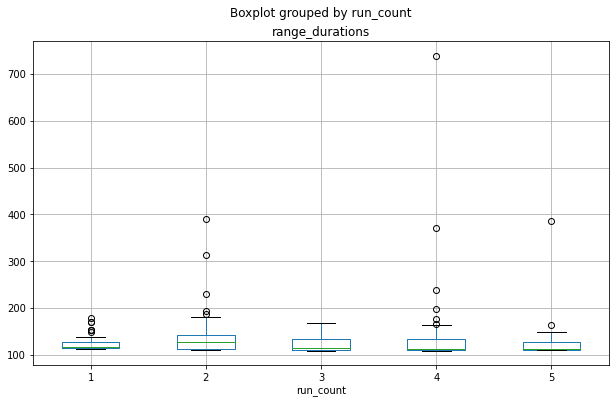

In [96]:
measurements = []
reset_lambda()
for i in range(50):
    reset_lambda()
    time.sleep(5) # sleep a bit for the change to propagate
    for j in range(5):
        measurements.append(bench_setup_1(32, [{"start": 0, "length": 10*MEGA}]))

df = pd.DataFrame.from_records(measurements)      
df.explode('range_durations').boxplot(column='range_durations', by='run_count', figsize = (10, 6))

### 100 MB chunks

<AxesSubplot:title={'center':'range_durations'}, xlabel='run_count'>

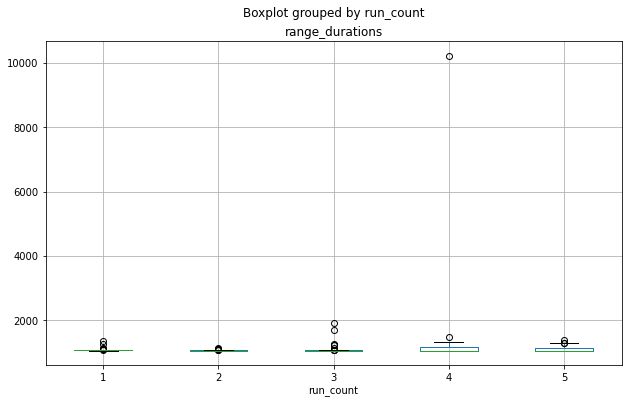

In [97]:
measurements = []
reset_lambda()
for i in range(50):
    reset_lambda()
    time.sleep(5) # sleep a bit for the change to propagate
    for j in range(5):
        measurements.append(bench_setup_1(32, [{"start": 0, "length": 100*MEGA}]))

df = pd.DataFrame.from_records(measurements)      
df.explode('range_durations').boxplot(column='range_durations', by='run_count', figsize = (10, 6))

## Observations

This boxplots show the distributions of the download durations accross invocations of the Lambda function.

- Reusing a container that already connected to S3 does not significantly improve the connection speed -> no unexpected DNS or other first time resolution at the container level.
- There are some outliers with some pretty large latencies